In [8]:
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from chord import Chord
from mpl_chord_diagram import chord_diagram
import scipy
import numpy as np

import scipy.cluster.hierarchy as hac

import plotly
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px

from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

from ipywidgets import interact, widgets

In [2]:
#data refactoring with pandas
data = pandas.read_table('1335.vdb.tab', sep = '\t', header = 0)
data = data.sort_values(by = ['OTUConTaxonomy'])
data = data.reset_index(drop=True)

list_taxon=['Domaine','Embranchement','Classe','Ordre',"Famille","Genre"]
for i in range(6):
    colname = list_taxon[i]
    data[colname]=data.apply(lambda row:row.OTUConTaxonomy.split(";")[i].split("(")[0],axis=1)
    
data['OTU'] = data.apply(lambda row:row.OTUNumber.replace('Otu',''), axis=1)
data = data.drop(columns=['OTUConTaxonomy','OTUNumber'])
data.columns=['Door1','Door2','FaucetHandle1','FaucetHandle2','SinkFloor1','SinkFloor2','Soap Dispenser','Stall','ToiletFloor1','ToiletFloor2','ToiletFlushHandle1','ToiletFlushHandle2','ToiletSeat1','ToiletSeat2','Domaine','Embranchement','Classe','Ordre','Famille','Genre','OTU']

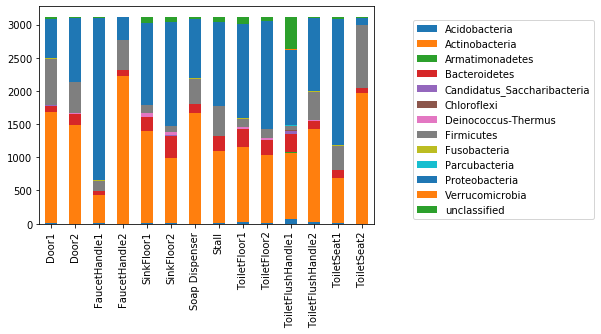

In [3]:
#Figure 1 : barplot
#EMB = data.groupby(by=['Embranchement']).sum()

AMB = pandas.pivot_table(data,columns = 'Embranchement',aggfunc='sum')
vec = AMB.apply(lambda col:col.sum()>=10, axis=0)


AMB=AMB.loc[:,vec]

ax = AMB.plot(kind="bar",stacked=True)
ax.legend(loc='lower left',fontsize=10, bbox_to_anchor=(1.1,0))

In [4]:
#Contruction du dataset pour les heatmaps
def get_dataset(data_set, section, threshold):
    AMB = pandas.pivot_table(data_set,columns = section,aggfunc='sum')
    vec = AMB.apply(lambda col:col.sum()>=threshold, axis=0)

    AMB=AMB.loc[:,vec]
    data_hm = pandas.DataFrame.transpose(AMB)
    return data_hm

data_hm = get_dataset(data, 'Embranchement',10)

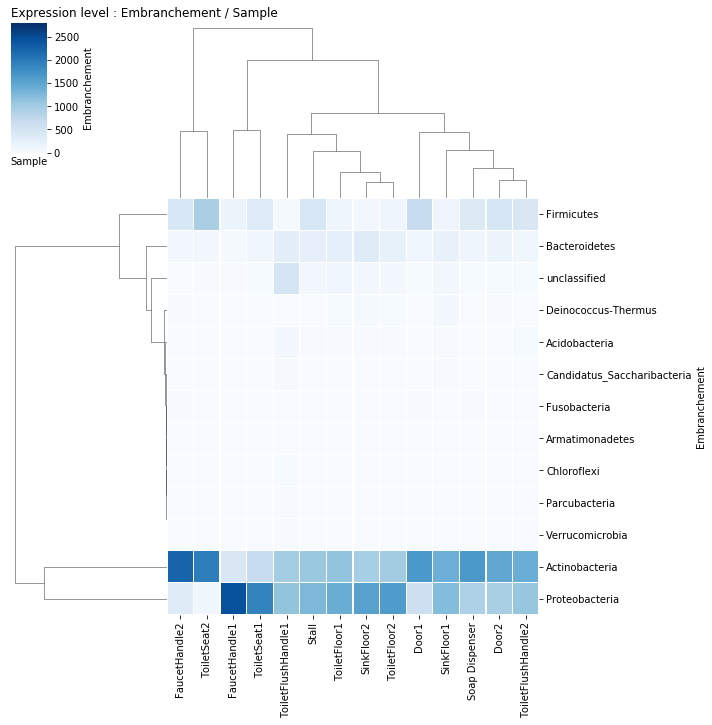

In [72]:
#Figure 2.1: clustering hierarchique
def get_clustering(data_set, section):
    #fig, ax = plt.subplots(figsize=(12, 10))
    
    # color map
    cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
    
    sns.clustermap(data_set, cmap="Blues", vmin= 0, vmax=2800,metric='euclidean', #euclidean
                   figsize=(10, 10),dendrogram_ratio=0.3,colors_ratio=0.003,cbar_pos=(0.02, 0.8, 0.05, 0.18),
                   linewidth=0.3, cbar_kws={"shrink": .8})
    
    # axis labels
    plt.xlabel('Sample')
    plt.ylabel(section)

    # title
    plt.title('Expression level : {} / Sample'.format(section), loc='left')

get_clustering(data_hm, 'Embranchement')

In [73]:
#Figure 2.2: heatmap
def get_heatmap(data, section):
    # get correlations
    fig, ax = plt.subplots(figsize=(12, 10))

    #corelation
    #print(data_hm)
    df_corr = data.corr()# irrelevant fields
    np.ones_like(df_corr, dtype=np.bool)

    # mask
    mask = np.triu(np.ones_like(df_corr, dtype=np.bool))

    # adjust mask and df
    mask = mask[1:, :-1]
    corr = df_corr.iloc[1:,:-1].copy()

    # color map
    cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)


    # plot heatmap
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="Blues",
               linewidths=0.3, vmin=-1, vmax=1, cbar=False,
               cbar_kws={"shrink": .8}, square=True)

    # ticks
    yticks = [i for i in corr.index]
    xticks = [i for i in corr.columns]

    plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
    plt.xticks(plt.xticks()[0], labels=xticks)

    # title
    plt.title('Expression level : Sample / Sample for the section "{}"'.format(section), loc='center')

#get_heatmap_2(data_hm, 'Embranchement')

In [74]:
@widgets.interact_manual(Threshold=(0,3000,100), Section=['Embranchement','Classe','Ordre','Famille','Genre','OTU'])
def show_correlation(Threshold,Section):
    data_hm = get_dataset(data, Section, Threshold)   
    get_clustering(data_hm, Section)
    get_heatmap(data_hm, Section)

interactive(children=(IntSlider(value=1500, description='Threshold', max=3000, step=100), Dropdown(description…

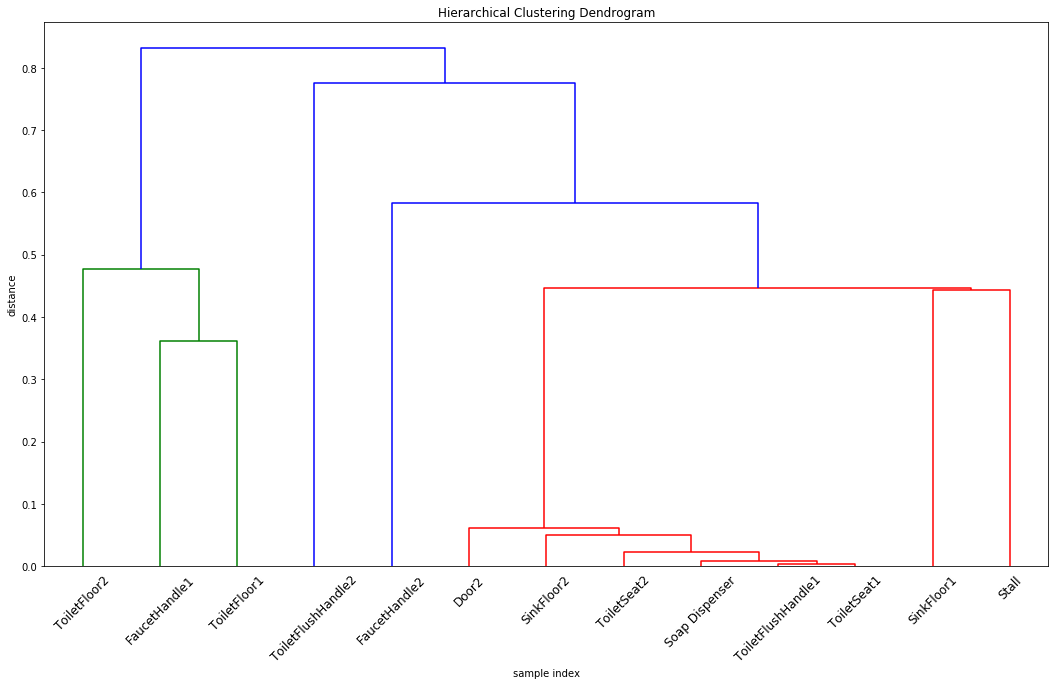

In [36]:
# Do the clustering

data_hm = get_dataset(data, 'Embranchement',10)
Z = hac.linkage(data_hm, method='single', metric='correlation', optimal_ordering=False)

# Plot dendogram
plt.figure(figsize=(18, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample name')
plt.ylabel('Distance')
hac.dendrogram(
       Z,
       leaf_rotation=45.,  # rotates the x axis labels
       leaf_font_size=12.,  # font size for the x axis labels
       labels = data_hm.columns
)
plt.show()

In [ ]:
#Figure 3 : chord diagram, bof bof...
# Now, matrix contains a 6x6 matrix of the values.
matrix = AMB.corr()

# Replacing negative values with 0’s, as features can be negatively correlated.
matrix[matrix < 0] = 0

# Multiplying all values by 100 for clarity, since correlation values lie b/w 0 and 1.
matrix = matrix.multiply(100).astype(int)

# Converting the DataFrame to a 2D List, as it is the required input format.
matrix = matrix.values.tolist()
names = list(AMB.columns)

chord_diagram(matrix, names,width=0.01,chordwidth=0.7,show=True,use_gradient=True,gap=0.3, sort="size")

In [9]:
#Figure 4 : Sunburst
#modéliser la présence des espèces par leur expression dans chacune des conditions

sample_choice = ['Door1','Door2','FaucetHandle1','FaucetHandle2','SinkFloor1','SinkFloor2','Soap Dispenser','Stall','ToiletFloor1','ToiletFloor2','ToiletFlushHandle1','ToiletFlushHandle2','ToiletSeat1','ToiletSeat2']
sample = sample_choice[0]
fig = px.sunburst(data, path=['Domaine','Embranchement','Classe','Ordre','Famille','Genre'], 
                  values=round((data[sample]/sum(data[sample]))*100,2),
                  color='Embranchement', branchvalues='total',template='ggplot2',title='sunburst',
                  color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_traces(textinfo='label+percent entry')
fig.update_layout(margin=dict(t=50,l=0,r=0,b=50))
fig.show()


In [10]:
#Figure 4.1 : Sunburst
#modéliser la présence des espèces par leur expression dans chacune des conditions

sample='FaucetHandle'

def make_figure(id_sample):
    # make sunburst
    sb1 = px.sunburst(data, path=['Domaine','Embranchement','Classe','Ordre','Famille','Genre'], 
                      values=round((data[str(id_sample)+"1"]/sum(data[str(id_sample)+"1"]))*100,2),
                      color='Embranchement', branchvalues='total',template='ggplot2',title='sunburst',
                      color_discrete_sequence=px.colors.qualitative.Pastel)._data

    sb2 = px.sunburst(data, path=['Domaine','Embranchement','Classe','Ordre','Famille','Genre'], 
                      values=round((data[str(id_sample)+"2"]/sum(data[str(id_sample)+"2"]))*100,2),
                      color='Embranchement', branchvalues='total',template='ggplot2',title='sunburst',
                      color_discrete_sequence=px.colors.qualitative.Pastel)._data

    # traces with separate domains to form a subplot
    trace1 = go.Sunburst(ids=sb1[0]['ids'],
                         labels=sb1[0]['labels'],
                         values=sb1[0]['values'],
                         parents=sb1[0]['parents'],
                         domain={'x': [0.0, 0.45], 'y': [0, 1]},
                         branchvalues ="total")

    trace2 = go.Sunburst(ids=sb2[0]['ids'],
                         labels=sb2[0]['labels'],
                         values=sb2[0]['values'],
                         parents=sb2[0]['parents'],
                         domain={'x': [0.55, 1.0], 'y': [0, 1]},
                         branchvalues ="total")

    # layout and figure production
    layout = go.Layout(height = 500,
                       width = 950,
                       autosize = False,
                       title = 'Side by side Sunburst diagrams by kind of paired sample : Sample 1 vs Sample 2')

    fig = go.Figure(data = [trace1, trace2], layout = layout)
    fig.update_traces(textinfo='label+percent entry')

    return fig

make_figure(sample).show()


In [11]:
#Figure 4.2 : Sunburst interactif pour tout les échantillons par paires via dash app
app = JupyterDash(__name__)

sample_choice = ['Door','FaucetHandle','SinkFloor','ToiletFloor','ToiletFlushHandle','ToiletSeat']

app.layout = html.Div([
    #html.H1("Sunburst by sample"),
    dcc.Graph(figure=make_figure(sample_choice[0]), id='graph'),
    html.Label([
        "Sample",
        dcc.Dropdown(
            id='sample-choice', clearable=False,
            value='Door', options=[
                {'label': c, 'value': c}
                for c in sample_choice
            ])
    ]),
])

# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("sample-choice", "value")]
)
def update_figure(sample): 
    return make_figure(sample) 

# Run app and display result inline in the notebook
app.run_server(mode='inline')

In [296]:
#Shutdown l'app précédente:
@classmethod
def _terminate_server_for_port(cls, host, port):
    shutdown_url = "http://{host}:{port}/_shutdown_{token}".format(
        host=host, port=port, token=JupyterDash._token
    )
    try:
        response = requests.get(shutdown_url)
    except Exception as e:
        pass

app._terminate_server_for_port("localhost", 8050)